# Vision artificelle et traintement des images

Ce notebook présente l'utilisation du modèle DenseNet121 pour classer les images de notre dataset. 

Le modèle est d'abord pré-entrainé sur le dataset TACO qui est présenté par la suite. 

Il est possible de ne pas lancer l'entrainement du modèle et de charger le modèle pré-entrainé sur notre dataset qui se nomme "densenet_TACO.pth". Ce modèle a été entrainé pendant 25 epochs. 

Les résultats du modèle sont présentés à la fin du notebook.

## Fine tuning de denseNet121 avec le dataset TACO

Le dataset utilisé est le dataset *taco-trash-dataset* de Kaggle disponible à l'adresse suivante :
https://www.kaggle.com/datasets/kneroma/tacotrashdataset

### Pré-traitement des données

In [ ]:
# Récupération des données via Kagglehub

import kagglehub
path = kagglehub.dataset_download("kneroma/tacotrashdataset")


100%|██████████| 2.79G/2.79G [00:27<00:00, 107MB/s]

Extracting files...


In [42]:
# Affichage des données
dataset_file = path + "/meta_df.csv"
import pandas as pd
df = pd.read_csv(dataset_file)
df.head()

,img_id,img_width,img_height,img_file,cat_id,cat_name,supercategory,ann_id,x,y,width,height,area
0,0,1537,2049,batch_1/000006.jpg,6,Glass bottle,Bottle,1,517.0,127.0,447.0,1322.0,403954.0
1,1,1537,2049,batch_1/000008.jpg,18,Meal carton,Carton,2,1.0,457.0,1429.0,1519.0,1071259.5
2,1,1537,2049,batch_1/000008.jpg,14,Other carton,Carton,3,531.0,292.0,1006.0,672.0,99583.5
3,2,1537,2049,batch_1/000010.jpg,5,Clear plastic bottle,Bottle,4,632.0,987.0,500.0,374.0,73832.5
4,2,1537,2049,batch_1/000010.jpg,7,Plastic bottle cap,Bottle cap,5,632.0,989.0,44.0,51.0,915.0


In [43]:
# Affichage des categories et des supercategories
categories = df['cat_name'].unique()
nb_categories = len(categories)
supercategories = df['supercategory'].unique()
nb_supercategories = len(supercategories)
nb_images = len(df)
#print(categories)
#print(supercategories)
print("categories :" + str(nb_categories))
print("super categories :" + str(nb_supercategories))
print("images :" + str(nb_images))

categories :59
super categories :28
images :4784


In [44]:
# Prétraitement du dataset
""" On ne garde que les supercategories et on enlève les annotations """

df = df.drop(['cat_id','cat_name', 'ann_id', 'x', 'y', 'width', 'height', 'area'], axis=1)
df.head()

,img_id,img_width,img_height,img_file,supercategory
0,0,1537,2049,batch_1/000006.jpg,Bottle
1,1,1537,2049,batch_1/000008.jpg,Carton
2,1,1537,2049,batch_1/000008.jpg,Carton
3,2,1537,2049,batch_1/000010.jpg,Bottle
4,2,1537,2049,batch_1/000010.jpg,Bottle cap


In [45]:
# Mélange du dataset et rétécissement
new_df = df.sample(frac=1).reset_index(drop=True)
new_df = new_df.head(4000)
new_df.head()

,img_id,img_width,img_height,img_file,supercategory
0,1102,3680,2760,batch_6/000077.JPG,Bottle
1,1123,3264,2448,batch_6/000057.JPG,Can
2,1314,3264,2448,batch_8/000014.jpg,Can
3,275,4032,3024,batch_11/000074.jpg,Plastic bag & wrapper
4,790,2448,3264,batch_3/IMG_5039.JPG,Lid


In [46]:
# Sauvegarde au format .csv
new_df.to_csv('trash_dataset.csv', index=False)

In [47]:
# Affichage des classes de new_df
new_df['supercategory'].unique()

array(['Bottle', 'Can', 'Plastic bag & wrapper', 'Lid', 'Other plastic',
       'Cigarette', 'Carton', 'Bottle cap', 'Straw', 'Unlabeled litter',
       'Blister pack', 'Cup', 'Styrofoam piece', 'Paper bag',
       'Plastic utensils', 'Paper', 'Plastic container', 'Aluminium foil',
       'Broken glass', 'Pop tab', 'Food waste', 'Rope & strings', 'Shoe',
       'Scrap metal', 'Plastic glooves', 'Squeezable tube', 'Battery',
       'Glass jar'], dtype=object)

In [48]:
### Création d'un dataset personnalisé

import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = sorted(self.data['supercategory'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['img_file'])
        image = Image.open(img_path).convert('RGB')
        label_name = self.data.iloc[idx]['supercategory']
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [ ]:
### Séparation des données en jeux d'entrainement, de validation et de test
from torch.utils.data import random_split

dataset = CustomImageDataset(csv_file='trash_dataset.csv', img_dir=path+'/data', transform=transform)
# Taille totale
dataset_size = len(dataset)
# mapping
print("Classes détectées :", dataset.class_to_idx)

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Découpage aléatoire
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Classes détectées : {'Aluminium foil': 0, 'Battery': 1, 'Blister pack': 2, 'Bottle': 3, 'Bottle cap': 4, 'Broken glass': 5, 'Can': 6, 'Carton': 7, 'Cigarette': 8, 'Cup': 9, 'Food waste': 10, 'Glass jar': 11, 'Lid': 12, 'Other plastic': 13, 'Paper': 14, 'Paper bag': 15, 'Plastic bag & wrapper': 16, 'Plastic container': 17, 'Plastic glooves': 18, 'Plastic utensils': 19, 'Pop tab': 20, 'Rope & strings': 21, 'Scrap metal': 22, 'Shoe': 23, 'Squeezable tube': 24, 'Straw': 25, 'Styrofoam piece': 26, 'Unlabeled litter': 27}


### Mise en place du modèle

In [37]:
## Mise en place du modèle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger DenseNet121 préentraîné
model = models.densenet121(pretrained=True)

# Geler les couches convolutionnelles
for param in model.parameters():
    param.requires_grad = False

# Adapter la dernière couche au nombre de classes
num_classes = len(dataset.classes)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

model = model.to(device)

# Perte et Optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Entrainement

Il est possible de sauter la partie entrainement et de récupérer le modèle pré-entrainé (densenet_TACO_25epochs.pth) par la suite. Ce modèle a été entrainé sur 25 epochs. 

Epoch 1/10 | Train Loss: 2.6353 | Train Acc: 23.89% | Val Loss: 2.4085 | Val Acc: 29.00%
Epoch 2/10 | Train Loss: 2.3023 | Train Acc: 32.11% | Val Loss: 2.2937 | Val Acc: 31.67%
Epoch 3/10 | Train Loss: 2.1510 | Train Acc: 36.11% | Val Loss: 2.2518 | Val Acc: 33.67%
Epoch 4/10 | Train Loss: 2.0510 | Train Acc: 37.71% | Val Loss: 2.3355 | Val Acc: 33.33%
Epoch 5/10 | Train Loss: 1.9683 | Train Acc: 40.11% | Val Loss: 2.2363 | Val Acc: 34.50%
Epoch 6/10 | Train Loss: 1.9018 | Train Acc: 41.14% | Val Loss: 2.2108 | Val Acc: 35.33%
Epoch 7/10 | Train Loss: 1.8424 | Train Acc: 43.04% | Val Loss: 2.2023 | Val Acc: 36.17%
Epoch 8/10 | Train Loss: 1.8074 | Train Acc: 43.68% | Val Loss: 2.2056 | Val Acc: 36.50%
Epoch 9/10 | Train Loss: 1.7632 | Train Acc: 45.39% | Val Loss: 2.2186 | Val Acc: 37.33%
Epoch 10/10 | Train Loss: 1.7386 | Train Acc: 44.68% | Val Loss: 2.2101 | Val Acc: 37.67%


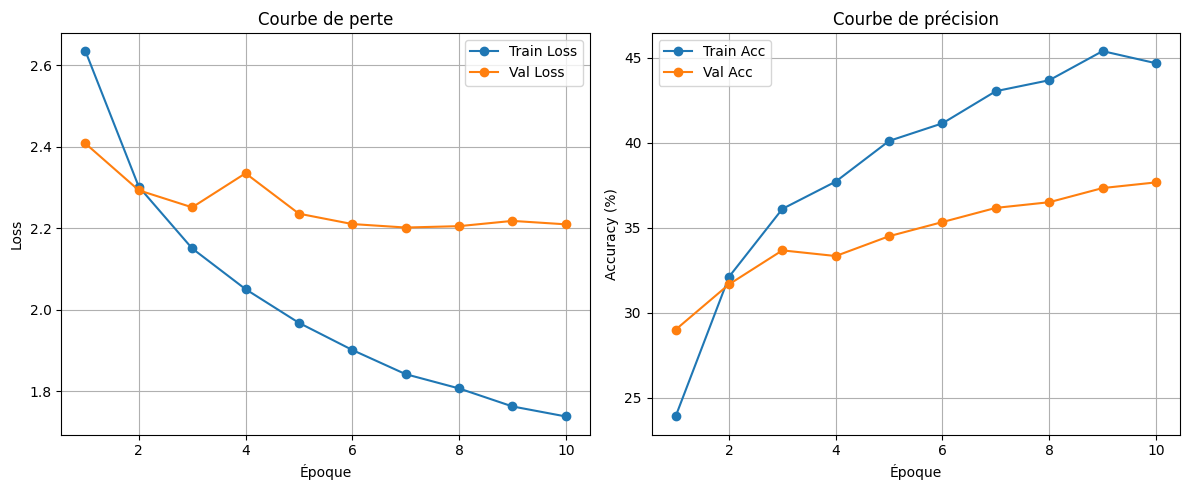

In [38]:
### Fine tuning avec le dataset

import torch
import matplotlib.pyplot as plt

num_epochs = 10

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.2f}%")

### Affichage des courbes
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Courbe des pertes
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title("Courbe de perte")
plt.xlabel("Époque")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Courbe des précisions
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', marker='o')
plt.plot(epochs, val_accuracies, label='Val Acc', marker='o')
plt.title("Courbe de précision")
plt.xlabel("Époque")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
### Sauvegarde du modèle
torch.save(model.state_dict(), "densenet121_finetuned.pth")

### Récupération du modèle pré-entrainé sur 25 epochs

In [ ]:
model = models.densenet121()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load("densenet_TACO.pth"))
model = model.to(device)

### Evaluation

In [40]:
### Evaluation du modèle
from sklearn.metrics import cohen_kappa_score, classification_report

model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {accuracy:.2f}%")

class_names = dataset.classes
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Kappa Score: {kappa:.4f}")

unique_labels = sorted(set(all_labels + all_preds))
label_names = [dataset.classes[i] for i in unique_labels]
print(classification_report(all_labels, all_preds, labels=unique_labels, target_names=label_names))



Test Accuracy: 31.50%
Kappa Score: 0.2357
                       precision    recall  f1-score   support

       Aluminium foil       0.30      0.50      0.38         6
         Blister pack       0.00      0.00      0.00         1
               Bottle       0.15      0.20      0.17        46
           Bottle cap       0.21      0.20      0.21        44
         Broken glass       0.83      0.75      0.79        20
                  Can       0.24      0.31      0.27        39
               Carton       0.33      0.39      0.36        23
            Cigarette       0.53      0.72      0.61        88
                  Cup       0.00      0.00      0.00        29
           Food waste       0.00      0.00      0.00         2
            Glass jar       0.00      0.00      0.00         1
                  Lid       0.00      0.00      0.00        13
        Other plastic       0.29      0.20      0.24        30
                Paper       0.00      0.00      0.00        23
            

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

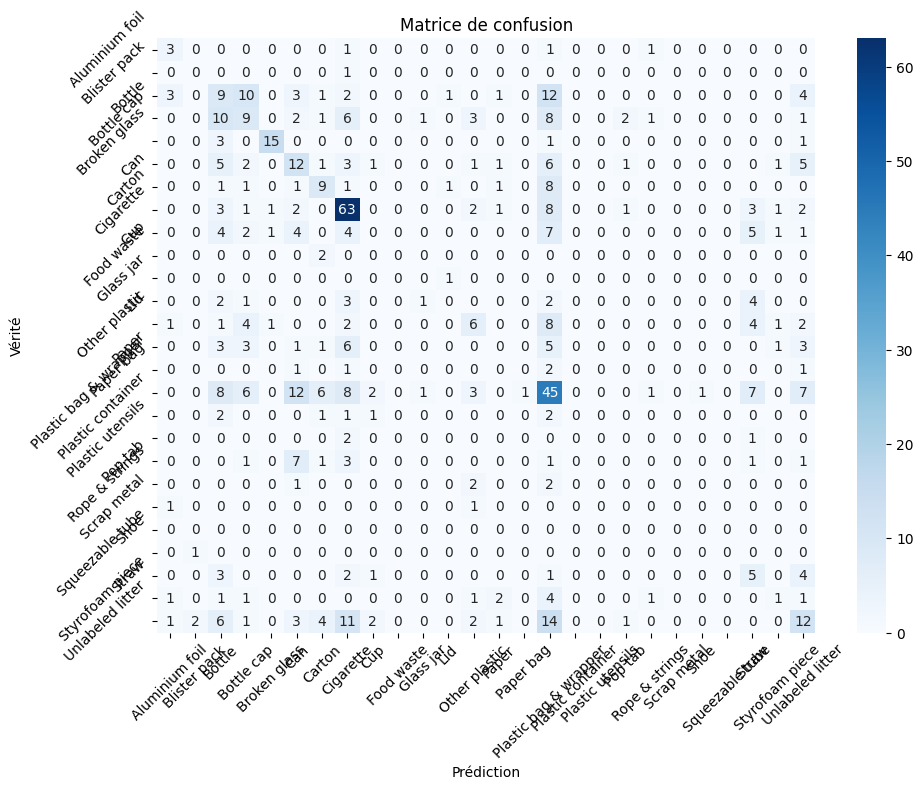

In [41]:
### Affichage d'une matrice de confusion pour plus de clareté
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.title("Matrice de confusion")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluation de DenseNet121 amélioré sur nos images

In [2]:
### Prédiction sur une image
import torch
from torchvision import transforms
from PIL import Image
import os
from torchvision import models

# Paramètres 
device = torch.device('cpu')

# Chargement du modèle
model = models.densenet121(pretrained=False)
num_features = model.classifier.in_features
model.classifier = torch.nn.Linear(num_features, 28)  # 28 classes

# Charger les poids du modèle
model.load_state_dict(torch.load('densenet121_finetuned.pth', map_location=device))
model.to(device)
model.eval()

# Remapping des classes
label_map = {
    0: 'Aluminium foil', 1: 'Battery', 2: 'Blister pack', 3: 'Bottle', 4: 'Bottle cap',
    5: 'Broken glass', 6: 'Can', 7: 'Carton', 8: 'Cigarette', 9: 'Cup', 10: 'Food waste',
    11: 'Glass jar', 12: 'Lid', 13: 'Other plastic', 14: 'Paper', 15: 'Paper bag',
    16: 'Plastic bag & wrapper', 17: 'Plastic container', 18: 'Plastic gloves', 19: 'Plastic utensils',
    20: 'Pop tab', 21: 'Rope & strings', 22: 'Scrap metal', 23: 'Shoe', 24: 'Squeezable tube',
    25: 'Straw', 26: 'Styrofoam piece', 27: 'Unlabeled litter'
}

# Transformer l'image
def transform_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Redimensionner l'image
        transforms.ToTensor(),  # Convertir l'image en tenseur
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation
    ])
    image = Image.open(image_path)  # Ouvrir l'image
    image = transform(image).unsqueeze(0)  # Appliquer les transformations et ajouter une dimension batch
    return image.to(device)

# Prédiction
def predict_image_class(image_path):
    # Transformer l'image
    image = transform_image(image_path)
    
    # Faire la prédiction
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)  # Obtenir la classe prédite
    
    predicted_label = label_map[predicted_class.item()]  # Récupérer le nom de la classe
    return predicted_label

# Exemple d'utilisation
image_path = 'data/bottle/mouvement_826.jpg'  # Remplacez par le chemin de votre image
predicted_label = predict_image_class(image_path)
print(f"Predicted label: {predicted_label}")


/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted label: Bottle


In [5]:
### Evaluation sur nos images 

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Chemin vers le dossier contenant les images
bottle_path = "data/bottle"
canette_path = "data/canette"

# Initialisation des prédictions et des labels réels
predictions = []
true_labels = []

# Prédictions sur les bouteilles
for filename in os.listdir(bottle_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(bottle_path, filename)
        predicted_label = predict_image_class(image_path)
        predictions.append(predicted_label)
        true_labels.append('Bottle')  

# Prédictions sur les canettes
for filename in os.listdir(canette_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_path = os.path.join(canette_path, filename)
        predicted_label = predict_image_class(image_path)
        predictions.append(predicted_label)
        true_labels.append('Can')  

# Calcul de l'accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(predictions)

Accuracy: 12.95%
['Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Carton', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Bottle', 'Bottle', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Bottle', 'Bottle', 'Plastic bag & wrapper', 'Bottle', 'Carton', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Plastic bag & wrapper', 'Carton', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Can', 'Bottle', 'Carton', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Bottle', 'Plastic bag & wrapper', 'Carton', 'Plastic bag & wrapper', 'Carton', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic bag & wrapper', 'Plastic b

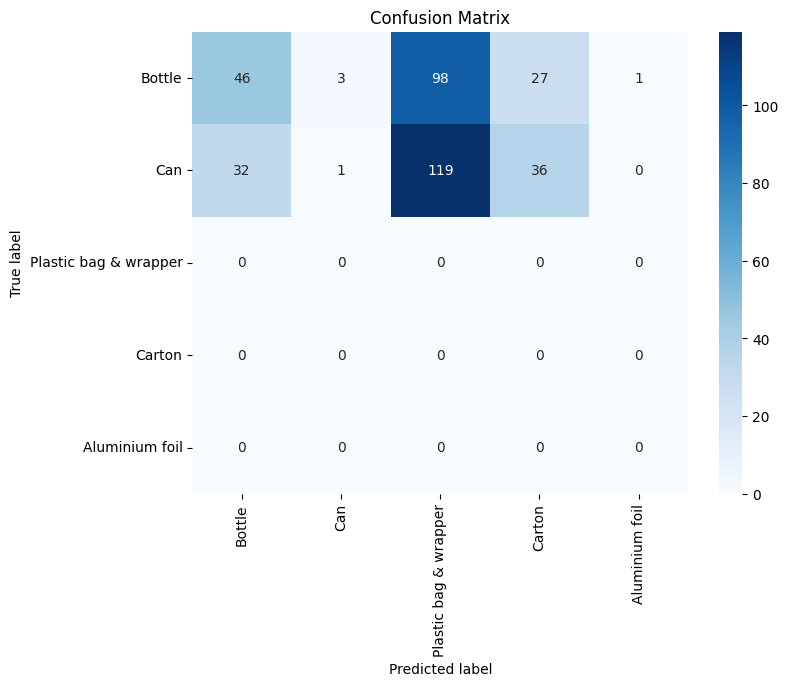

In [6]:
# Création de la matrice de confusion
labels = ['Bottle', 'Can', 'Plastic bag & wrapper', 'Carton', 'Aluminium foil']
cm = confusion_matrix(true_labels, predictions, labels=labels)

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

Les résultats sur notre dataset sont assez mauvais. Beaucoup de déchets sont reconnus comme étant des sacs plastiques ou emballages. Les bouteilles sont mieux reconnus que les autres déchets. 

Le dataset n'est paut être pas très adapté pour l'entrainement d'un classeur. En effet, il y a peut être un trop grand impact du fond sur la classification. 